## Plot performance of models against underlying price

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from sklearn.neural_network import MLPClassifier

sys.path += ['../']
from functions import plot_performace

plt.rcParams["figure.figsize"] = (6, 5)
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 11.5})
plt.rc('axes', labelsize=13)

### BTC Movement

In [2]:
coin = 'btc'

In [3]:
data = pd.read_parquet(f'../../4_eda/{coin}_stationary_data_lagged.parquet.gzip')
data.columns = data.columns.map('_'.join)
data = (data.fillna(method='ffill')
            .fillna(0)
            .replace([np.inf, -np.inf], 0))
targets = pd.read_parquet(f'../../2_data_processing/numeric_data/{coin}_targets.parquet.gzip')
price_data = pd.read_parquet(f'../../2_data_processing/numeric_data/{coin}_price_data.parquet.gzip').iloc[:,0]

In [98]:
with open(f'../../4_eda/{coin}_causality/{coin}_price_log_difference_causality.txt') as f:
    price_log_difference_vars = f.read().splitlines()
X = data[price_log_difference_vars]

X_train = X.head(3424)
X_test = X.tail(800).head(300)
targets_train = targets.head(3424)
targets_test = targets.tail(800).head(300)
price_data_test = price_data.tail(800).head(300)

y_train = (targets_train[f'{coin}_price_log_difference'] > 0) * 1
y_test = (targets_test[f'{coin}_price_log_difference'] > 0) * 1

model_config = {
    'hidden_layer_sizes': (158, 51),
    'activation': 'identity',
    'solver': 'adam',
    'alpha': 0.044691007322786185,
    'learning_rate_init': 0.003005953131985203,
    'batch_size': 32,
}
model = MLPClassifier(**model_config).fit(X_train, y_train)

y_pred = model.predict_proba(X_test)[:,1]

In [99]:
y_pred_d = (y_pred >= 0.5) * 1
y_pred_d = pd.Series(y_pred_d, index=X_test.index)

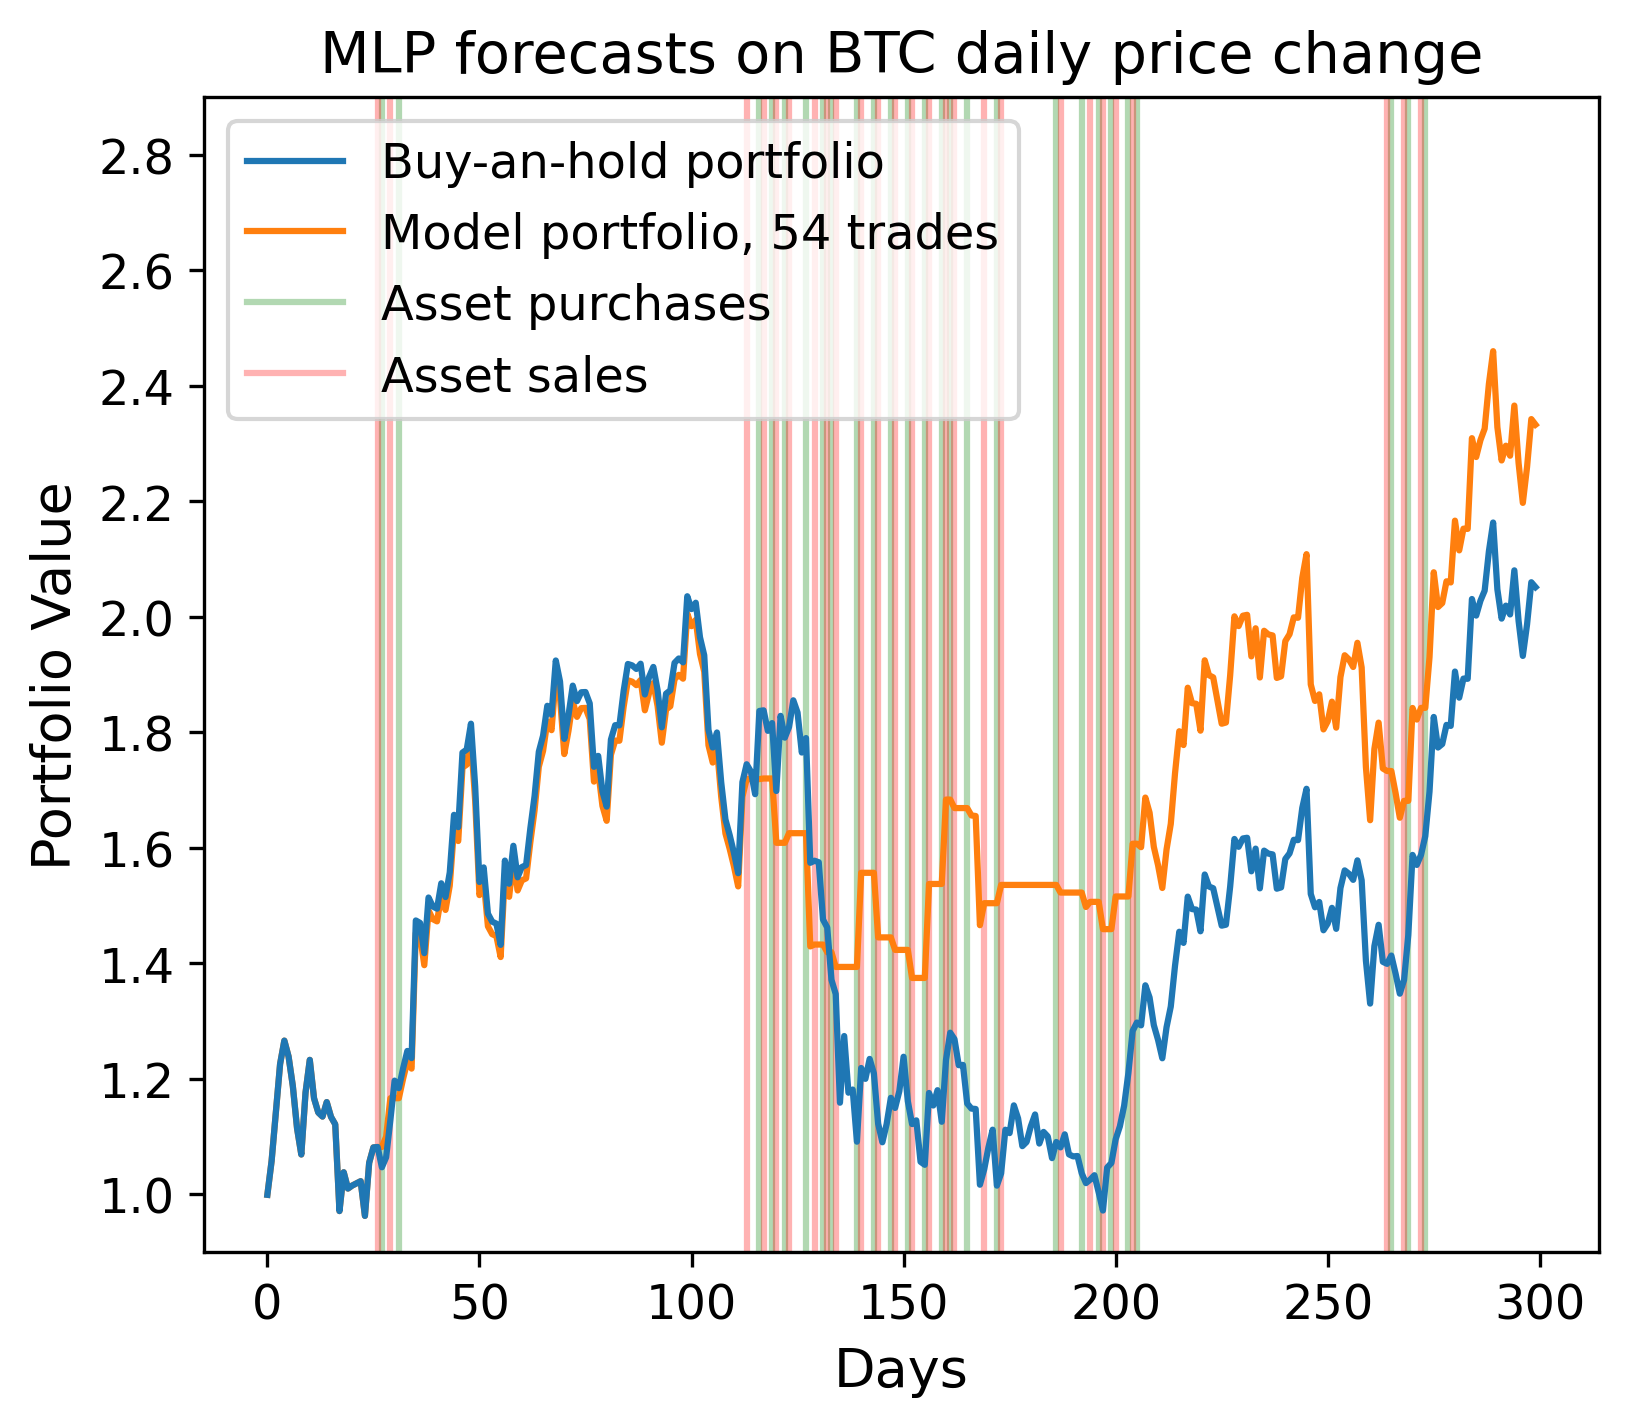

In [100]:
ax1 = plot_performace(price_data_test, y_pred_d, 'movement')
plt.title('MLP forecasts on BTC daily price change')

loc = plticker.MultipleLocator(base=0.2) # this locator puts ticks at regular intervals
ax1.yaxis.set_major_locator(loc)
ax1.set_ylim(0.9, 2.9)
plt.show()

### BTC 7d extrema

In [55]:
timeframe = 7

with open(f'../../4_eda/{coin}_causality/{coin}_price_min_{timeframe}d_causality.txt') as f:
    price_min_vars = f.read().splitlines()
with open(f'../../4_eda/{coin}_causality/{coin}_price_max_{timeframe}d_causality.txt') as f:
    price_max_vars = f.read().splitlines()
X_min = data[price_min_vars]
X_max = data[price_max_vars]

X_min_train = X_min.head(3420)
X_min_test = X_min.tail(800).head(300)
X_max_train = X_max.head(3420)
X_max_test = X_max.tail(800).head(300)
targets_train = targets.head(3420)
targets_test = targets.tail(800).head(300)
price_data_test = price_data.tail(800).head(300)

y_min_train = targets_train[f'{coin}_price_min_{timeframe}d']
y_max_train = targets_train[f'{coin}_price_max_{timeframe}d']
y_min_test = targets_test[f'{coin}_price_min_{timeframe}d']
y_min_test = targets_test[f'{coin}_price_max_{timeframe}d']

model_config = {
    'hidden_layer_sizes': (158, 51),
    'activation': 'identity',
    'solver': 'adam',
    'alpha': 0.044691007322786185,
    'learning_rate_init': 0.003005953131985203,
    'batch_size': 32,
}
min_model = MLPClassifier(**model_config).fit(X_min_train, y_min_train)
max_model = MLPClassifier(**model_config).fit(X_max_train, y_max_train)

y_min_pred = min_model.predict_proba(X_min_test)[:,1]
y_max_pred = max_model.predict_proba(X_max_test)[:,1]

In [90]:
y_min_pred_d = (y_min_pred >= 0.1) * 1
y_min_pred_d = pd.Series(y_min_pred_d, index=X_min_test.index)

y_max_pred_d = (y_max_pred >= 0.1) * 1
y_max_pred_d = pd.Series(y_max_pred_d, index=X_max_test.index)

y_pred = pd.DataFrame({
    'min': y_min_pred_d,
    'max': y_max_pred_d,
})

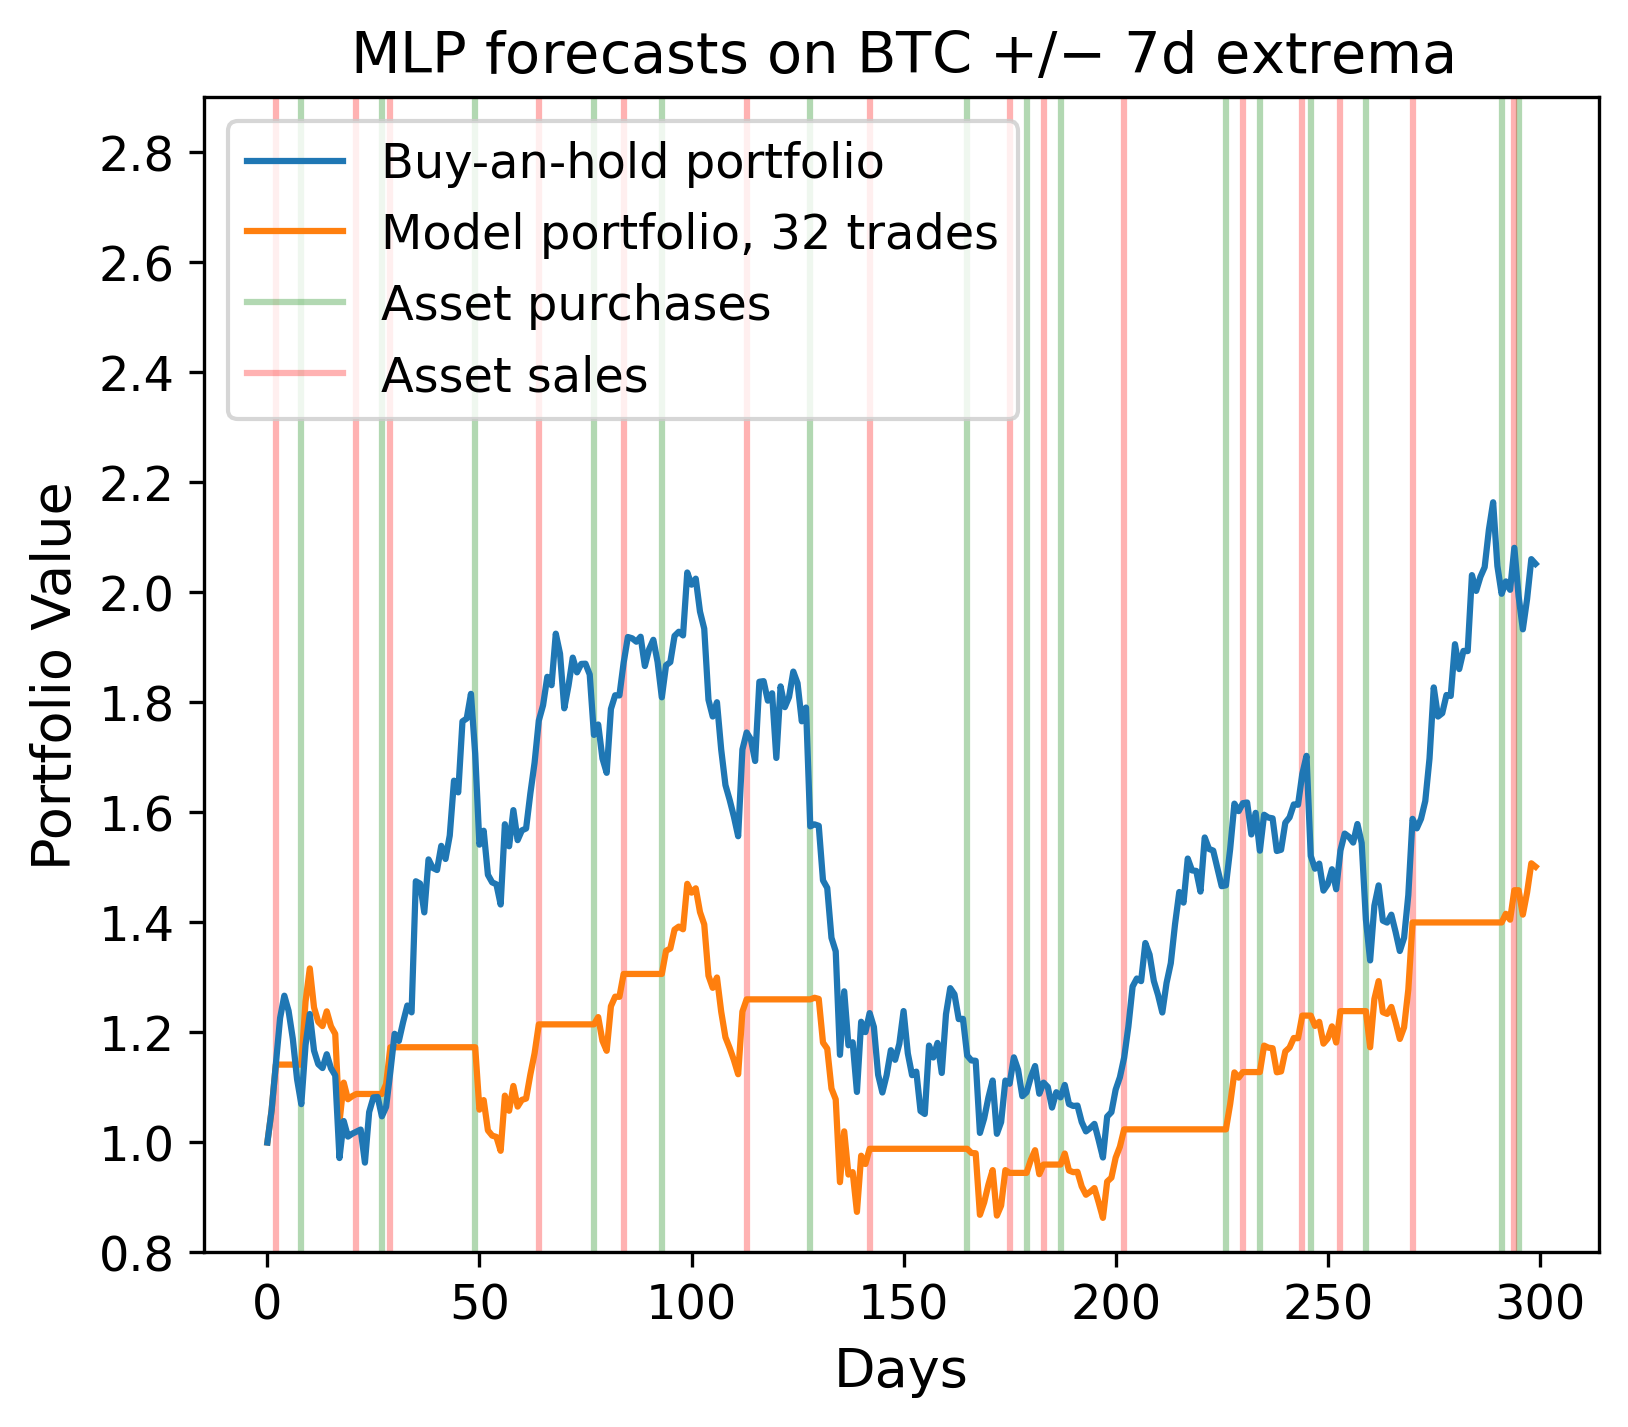

In [96]:
ax = plot_performace(price_data_test, y_pred, 'extrema')
plt.title(f'MLP forecasts on BTC +/$-$ {timeframe}d extrema')

# reposition legend
legend = ax.get_legend()
handles, labels = legend.legendHandles, [t.get_text() for t in legend.get_texts()]
ax.legend(handles=handles, labels=labels, loc='upper left')

loc = plticker.MultipleLocator(base=0.2) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
ax.set_ylim(0.8, 2.9)
plt.show()